# Assignment 3: Clustering California Housing with K-means

### CS 4501 Machine Learning - Department of Computer Science - University of Virginia
"Tonight, more than 130,000 Californians will go to sleep homeless. That’s enough to fill Dodger Stadium, AT&T Park and Petco Park. The biggest culprit is rising housing costs. From 2000 to 2014, median rent in California increased by more than one-third, while real incomes for renters fell by 7 percent. Today, 1.5 million Californians spend more than half their income on housing. This crisis threatens not just low-income families but our entire economy, driving businesses to relocate to states in which their employees can afford to live. - **Business Insider, Sep 2018.**"

![Half of the homes in San Franciso is now one million or above](https://amp.businessinsider.com/images/573de0b88d3eaea27198a55d-960-480.jpg)

In this assignment, you will attempt to cluster the California Housing by implementing and analyzing the k-means algorithm to the data. K-Means is one of the most popular clustering algorithms. K-means stores k-centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. For references, you may refer to my lecture 9 or Chapter 2 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit this Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


---
## 1. PRE-PROCESSING THE DATA (10 pts)

Download the California Housing dataset from the below link. This dataset includes statistics about the median income, median age, average number of rooms per person, average number of persons in a household etc. The statistics were gathered per geographical block.

**Data Acquiring:** Download the dataset from https://www.kaggle.com/camnugent/california-housing-prices

**Data Discovery, Visualization, and Cleaning:** Fortunately, this step have been given to you (for free) from chapter 2. However, you should review them and write the code necessary for the purposes of this assignment. 

In [1]:
# Sources used: 
#        Chapter 2: End to End Machine Learning Project
#        notebook/handson-ml/02_end_to_end_machine_learning_project.ipynb


# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from copy import deepcopy
from datascience import *


# Reading csv file:
housing = pd.read_csv( "housing.csv" )


# Dropping categorical feature 'ocean_proximity' since categorical features are not suitable for the k-m algorithm:
housing = housing.drop('ocean_proximity', axis=1)
housing = housing.drop('median_house_value', axis=1)

# Getting an idea of how the data looks: 
print("\n")
print( housing.head() )
print("\n\n\n\n")


# Getting an idea of the size & types of the different features:
housing.info()
print("\n\n\n\n")


# Getting some basic statistics: 
print( housing.describe() )
print("\n\n\n\n")


# Decided to drop the feature "median_house_value" because it is the Y value, which is not used in clustering







   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  
0       322.0       126.0         8.3252  
1      2401.0      1138.0         8.3014  
2       496.0       177.0         7.2574  
3       558.0       219.0         5.6431  
4       565.0       259.0         3.8462  





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null floa

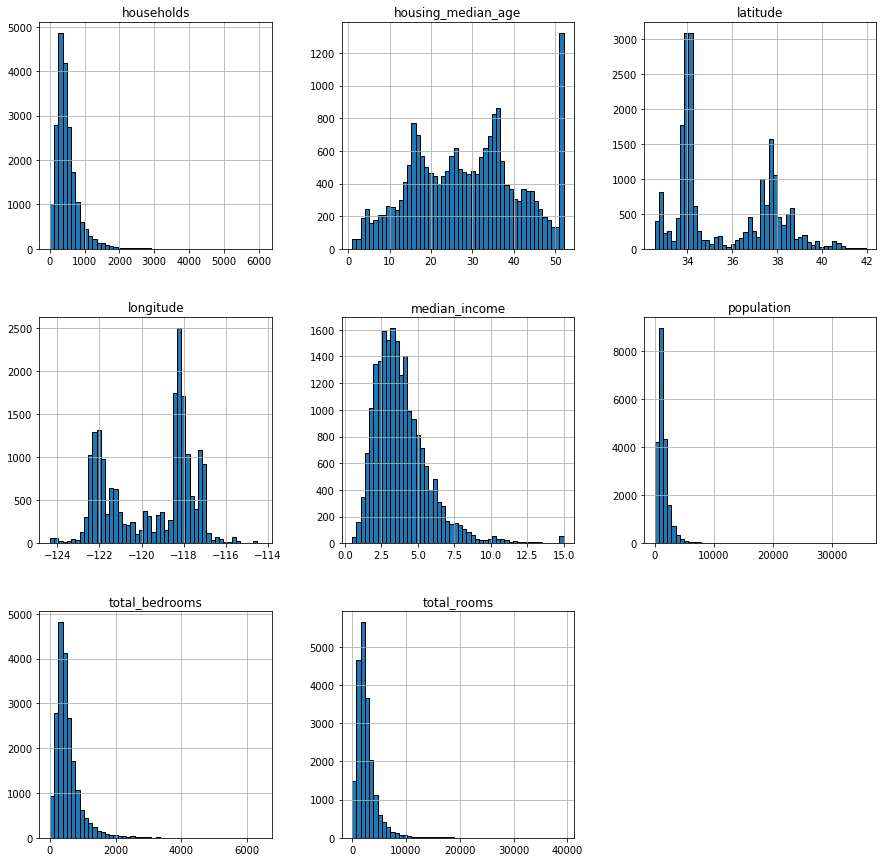

In [2]:
# Exploring and visualizing the data through historgrams:
housing.hist( bins=50, figsize=(15,15) )
print("\n\n\n\n")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d1d9400>,
      dtype=object)

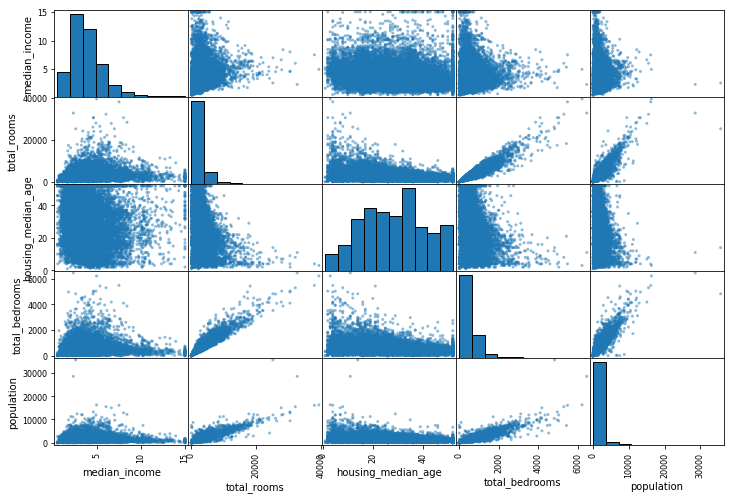

In [3]:
# Using scatter matrix to visualize relationships between features:
attributes = ["median_income", "total_rooms", "housing_median_age", "total_bedrooms", "population"]
scatter_matrix(housing[attributes], figsize=(12, 8))



In [4]:
# Using Pipeline with Imputer to fill in missing values and Standard Scaler to scale/normalize our data:
pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
    ])

pipeline1 = Pipeline([
        ('std_scaler', StandardScaler()),
    ])


# Preparing data for clustering:
prepared_data = pipeline.fit_transform(housing)
prepared_data = pipeline1.fit_transform(prepared_data)




- - -
## 2. IMPLEMENTING K-MEANS (40 pts)

You must implement your own version of K-Means Algorithm. Input a cluster count K and M data points each with its own vector of N features, along with the choice of a distance measure; then:

1. Initialize K centroids. In our case, a centroid is just the average of all data in a cluster.
2. Assign each data point to the cluster that has the closest centroid base on a **distance measure** below.
3. After all data points have been assigned to clusters, recalculate the centroids for each cluster (as averages of all points in the cluster).
4. Repeat the data assignments and centroid calculations until no change in housing assignment occurs between iterations.

**Distance Measures:** Your implementation must include the Euclidean distance which is:
$d(\mathbf{x},\mathbf{y}) = \sqrt[\leftroot{2}\uproot{2}2]{\sum\limits_{i=1}^n|x_i - y_i|^2}$

**Implementation Notes:** Note that your functions should return distance measures; that is, the returned value should be high if the two vectors are dissimilar, low if they are similar, and zero if they are completely identical.

In [5]:
# Sources: 
#      https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
#      https://stackoverflow.com/questions/35952124/how-to-choose-initial-centroids-for-k-means-clustering
#      https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html
#      https://hlab.stanford.edu/brian/error_sum_of_squares.html


# Helper function to get Euclidean Distance between data points and a centroid
def getEuclideanDistance( prepared_data, centroid ):

    # Get Euclidean Distance between all of the data and one centroid
    return np.linalg.norm( prepared_data - centroid , axis=1 )


# Helper function to randomize the initial k centroids. Returns randomized initial centroids. 
def randomize_K_centroids( k, number_of_features, prepared_data ):

    # Use average & standard deviation to represent the whole data accurately
    average = np.mean( prepared_data, axis = 0 )
    standard_deviation = np.std( prepared_data, axis = 0 )

    # Randomizing centroids in feature space
    random_seed = np.random.seed(seed=42)
    centroids = np.random.randn( k, number_of_features ) * standard_deviation + average
    return centroids
    
    
# K_Means algorithm implementation. Returns centroids and the corresponding clusters.
def K_Means( k, prepared_data ):

    # Getting number of rows in data and number of features
    size_of_training_data = prepared_data.shape[0]
    number_of_features = prepared_data.shape[1]


    # Initializing random centroids using randomize_K_centroids function defined above
    centroids = randomize_K_centroids( k, number_of_features, prepared_data )


    # Initializing "converge" boolean
    converge = np.linalg.norm( centroids - np.zeros(centroids.shape) ) == 0
    

    # Initializing cluster indexes
    clusters = np.zeros( size_of_training_data )


    # Initializing the distances from all data points to centroids 
    distances_to_centroids = np.zeros( ( size_of_training_data , k ) )


    # Initializing cluster data 
    cluster_data = {}
    
    
    # Run this loop until k-means converges
    while converge == False:

        # Updating distances to centroids
        for i in range( len(centroids) ):
            distances_to_centroids[:, i] = getEuclideanDistance( prepared_data, centroids[i] )

        # Updating new clusters (by getting the indexes)
        clusters = np.argmin( distances_to_centroids, axis=1 )
        
        # Keeping a copy of the old centroids to determine convergence later on
        old_centroids = deepcopy( centroids )

        # Updating centroid locations by averaging within the clusters
        for i in range( len( centroids ) ):
            centroids[i] = np.mean( prepared_data[clusters == i], axis=0 )

        # Updating cluster data 
        for i in range( len ( centroids ) ):
            cluster_data[i] = prepared_data[clusters == i]
            
        # Updating "converge" boolean 
        converge = np.linalg.norm( centroids - old_centroids ) == 0
        
    # Return the coordinates of all the centroids and the data points that belong to each centroid
    return [centroids, cluster_data]


# Sum of squared error function. Returns a list of of the SSE and the distances from data points to centroids
def sum_squared_error( k, prepared_data ):
    
    # Sum up all the distances ( which have already been squared) and then add them, for each cluster 
    cluster_data = K_Means( k, prepared_data )[1]
    centroids = K_Means( k, prepared_data )[0]
    distances = {}
    
    # Initialize list of the SSE ( len( list_of_SSE ) ) == k
    list_of_SSE = []
    
    for i in range( len( centroids ) ):
        distances[i] = getEuclideanDistance( cluster_data[i], centroids[i] )      
        list_of_SSE.append( np.sum( np.square( distances[i] ) ) )
        
    return [ list_of_SSE, distances ]



- - -
## 3. CLUSTERING HOUSING INTO REGIONS (40 pts)

Now that you have implemented the K-Means as the clustering algorithm. Applying the algorithm for k=2 clusters to see if you can split California into a Northern and Southern regions.

* **Cluster the data:** Write down the SSE (sum squared error), cluster means, within cluster standard deviations for each attribute, etc. Visualize the clustering by plot the latitude along the X axis and longitude along the Y axis. You should get a plot that looks roughly in the shape of California (see Chapter 2 for more details). Using the cluster means and std. deviations as representative values in the cluster, what can you say about the clusters that were found? How do they compare with what you know about cities and areas in California? What can you attribute the gaps to? It will definitely be helpful to have a map of California handy.

* **Change the number of clusters:** Change k from 2 to 10 and repeat the clustering process above. Record cluster means and standard deviations. When you change k, do any additional patterns emerge? If so, what are they? Applying the algorithm for 10 clusters to see if it clearly identified the silicon valley area as one cluster (where houses are relatively new and expensive, median income is high), the area of San Francisco as another etc. While SF and Silicon Valley may have a somewhat similar profile (at least, compared with mid CA), they were separated mainly due to the latitude/longtitue properties, that involve a dimension of geographical cohesiveness.

**Implementation Notes:** For each k, report the training and validation accuracy. Identify the k with the highest validation accuracy, and report the test accuracy with this choice of k. Note: if multiple values of k result in the highest validation accuracy, then report test accuracies for all such values of k. Then, plot the data points with different markers corresponding to different classes. Repeat this process for all k and discuss the smoothness of the regions as k increases.


In [6]:
# Running k_Means with k = 2
K_means = K_Means( 2, prepared_data )
first_cluster = K_means[1][0]
second_cluster = K_means[1][1]
print("\n")


# SSE with k = 2 
first_cluster_SSE = sum_squared_error( 2, prepared_data )[0][0]
second_cluster_SSE = sum_squared_error( 2, prepared_data )[0][1]
print("SSE of the first cluster:", first_cluster_SSE)
print("SSE of the second cluster:", second_cluster_SSE)
print("\n")


# Getting the centroids of the two clusters 
first_cluster_centroid = K_means[0][0]
second_cluster_centroid = K_means[0][1]
print( "Centroid of first cluster:", first_cluster_centroid )
print()
print( "Centroid of first cluster:", second_cluster_centroid )
print("\n")


# Intra-cluster distances from data points to centroids in order to get means and standard deviations
distances_within_clusters = sum_squared_error( 2, prepared_data )[1]


# Getting means of distances of the 2 clusters
first_cluster_mean_of_distances = np.mean( distances_within_clusters[0] )
second_cluster_mean_of_distances = np.mean( distances_within_clusters[1] )
print("Mean of the distances in first cluster:", first_cluster_mean_of_distances)
print("Mean of the distances in second cluster:", second_cluster_mean_of_distances)
print("\n")


# Getting std deviations of distances of 2 clusters 
first_cluster_std = np.std( distances_within_clusters[0] )
second_cluster_std = np.std( distances_within_clusters[1] )
print("Standard Deviation of the first cluster:", first_cluster_std)
print("Standard Deviation of the second cluster:", second_cluster_std)
print("\n")







SSE of the first cluster: 31601.20091174168
SSE of the second cluster: 89805.10694351656


Centroid of first cluster: [ 0.18980755 -0.17590801 -0.87918605  1.92974503  2.00918845  1.86076312
  2.01052371  0.1455907 ]

Centroid of first cluster: [-0.02492759  0.02310215  0.11546425 -0.25343505 -0.26386842 -0.2443756
 -0.26404378 -0.01912055]


Mean of the distances in first cluster: 2.961416442889267
Mean of the distances in second cluster: 2.117191087195081


Standard Deviation of the first cluster: 2.1021802047588443
Standard Deviation of the second cluster: 0.6632857728594826




In [7]:
# Unscaling features to get the real latitude and longitude values in order to plot later on
unscaled_first_cluster = pipeline1.inverse_transform(first_cluster)
unscaled_second_cluster = pipeline1.inverse_transform(second_cluster)


# Converting cluster data to Pandas Dataframe in order to plot later on 
dataframe_first_cluster = pd.DataFrame(unscaled_first_cluster)
dataframe_second_cluster = pd.DataFrame(unscaled_second_cluster)


# Unscaling centroid data in order to plot later on
first_unscaled_centroid = pipeline1.inverse_transform( first_cluster_centroid )
second_unscaled_centroid = pipeline1.inverse_transform( second_cluster_centroid )


# Converting centroid data to Pandas Dataframe in order to plot later on 
first_dataframe_centroid = pd.DataFrame( first_unscaled_centroid )
first_centroid_lat_long = pd.DataFrame( {"longitude": [first_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [first_dataframe_centroid.iat[1, 0]] } )                                   


second_dataframe_centroid = pd.DataFrame( second_unscaled_centroid )
second_centroid_lat_long = pd.DataFrame( {"longitude": [ second_dataframe_centroid.iat[0, 0]], 
                                          "latitude": [second_dataframe_centroid.iat[1, 0]] } ) 

lat_long = pd.merge(first_centroid_lat_long, second_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)




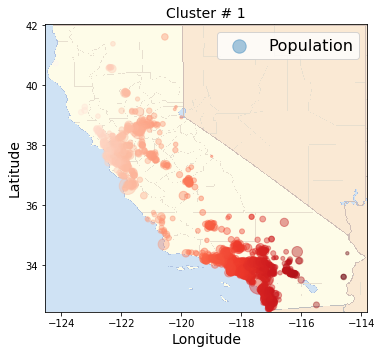

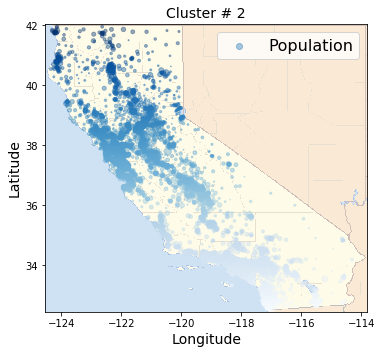

In [8]:
# Plotting first cluster of California
california_img= mpimg.imread( "california.png" )
south = dataframe_first_cluster.plot(kind="scatter", x=0, y=1, figsize=(8,5.3),
                       s=dataframe_first_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Reds'), c=0,
                       colorbar=False, alpha=0.4)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.title( "Cluster # 1", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)

plt.show()


#Plotting second cluster of California
north = dataframe_second_cluster.plot(kind="scatter", x=0, y=1, figsize=(8,5.3),
                       s=dataframe_second_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Blues'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 2", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)


plt.show()



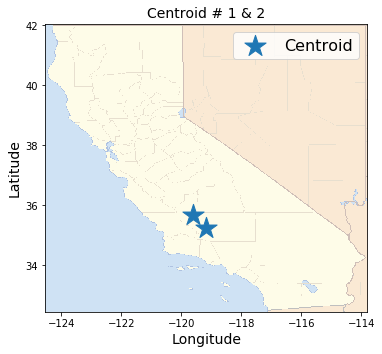

In [9]:
# Plotting latitude and longitude of centroids
         
first_centroid = lat_long.plot(kind="scatter", x='longitude', y='latitude', 
                                              figsize=(8,5.3), marker="*", label="Centroid", s=500)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))

plt.title( "Centroid # 1 & 2", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)



# K = 2 Analysis:
    # In many of the runs of K_Means, the centroids seem to be pretty close together. However, one of the centroids  
    # always seems to be positioned towards the northern part of California, while the other centroid seems to be 
    # positioned more towards the South. In the figures above, the clusters seem to split consistently into 
    # two areas: Northern data points, which contain some coastal data points close to San Francisco and Bay Area, 
    # as well as some rural areas in the north-western part of California. On the other hand, the Southern cluster 
    # mainly represents some of the San Diego, LA and Santa Barbara regions as well as some more rural south western 
    # regions in California. I attribute the differences in these 2 clusters mainly to location (latitude, longitude)
    # as well as total rooms/bed rooms. As we know, in the Bay Area, Silicon Valley and San Francisco, the 
    # housing prices are increasing exponentially and the number of rooms and bedrooms in homes are decreasing. This
    # basically means that the rent goes up and they pay for less space. 

In [10]:
# Running k_Means with k = 10
K_means = K_Means( 10, prepared_data )
first_cluster = K_means[1][0]
second_cluster = K_means[1][1]
third_cluster = K_means[1][2]
fourth_cluster = K_means[1][3]
fifth_cluster = K_means[1][4]
sixth_cluster = K_means[1][5]
seventh_cluster = K_means[1][6]
eighth_cluster = K_means[1][7]
ninth_cluster = K_means[1][8]
tenth_cluster = K_means[1][9]

print("\n")


# SSE with k = 10
first_cluster_SSE = sum_squared_error( 10, prepared_data )[0][0]
second_cluster_SSE = sum_squared_error( 10, prepared_data )[0][1]
third_cluster_SSE = sum_squared_error( 10, prepared_data )[0][2]
fourth_cluster_SSE = sum_squared_error( 10, prepared_data )[0][3]
fifth_cluster_SSE = sum_squared_error( 10, prepared_data )[0][4]
sixth_cluster_SSE = sum_squared_error( 10, prepared_data )[0][5]
seventh_cluster_SSE = sum_squared_error( 10, prepared_data )[0][6]
eighth_cluster_SSE = sum_squared_error( 10, prepared_data )[0][7]
ninth_cluster_SSE = sum_squared_error( 10, prepared_data )[0][8]
tenth_cluster_SSE = sum_squared_error( 10, prepared_data )[0][9]

print("SSE of the first cluster:", first_cluster_SSE)
print("SSE of the second cluster:", second_cluster_SSE)
print("SSE of the third cluster:", third_cluster_SSE)
print("SSE of the fourth cluster:", fourth_cluster_SSE)
print("SSE of the fifth cluster:", fifth_cluster_SSE)
print("SSE of the sixth cluster:", sixth_cluster_SSE)
print("SSE of the seventh cluster:", seventh_cluster_SSE)
print("SSE of the eighth cluster:", eighth_cluster_SSE)
print("SSE of the ninth cluster:", ninth_cluster_SSE)
print("SSE of the tenth cluster:", tenth_cluster_SSE)

print("\n")



# Getting the centroids of the 10 clusters 
first_cluster_centroid = K_means[0][0]
second_cluster_centroid = K_means[0][1]
third_cluster_centroid = K_means[0][2]
fourth_cluster_centroid = K_means[0][3]
fifth_cluster_centroid = K_means[0][4]
sixth_cluster_centroid = K_means[0][5]
seventh_cluster_centroid = K_means[0][6]
eighth_cluster_centroid = K_means[0][7]
nineth_cluster_centroid = K_means[0][8]
tenth_cluster_centroid = K_means[0][9]

print( "Centroid of first cluster:", first_cluster_centroid )
print()
print( "Centroid of second cluster:", second_cluster_centroid )
print()
print( "Centroid of third cluster:", third_cluster_centroid )
print()
print( "Centroid of fourth cluster:", fourth_cluster_centroid )
print()
print( "Centroid of fifth cluster:", fifth_cluster_centroid )
print()
print( "Centroid of sixth cluster:", sixth_cluster_centroid )
print()
print( "Centroid of seventh cluster:", seventh_cluster_centroid )
print()
print( "Centroid of eighth cluster:", eighth_cluster_centroid )
print()
print( "Centroid of nineth cluster:", nineth_cluster_centroid )
print()
print( "Centroid of tenth cluster:", tenth_cluster_centroid )


print("\n")


# Intra-cluster distances from data points to centroids in order to get means and standard deviations
distances_within_clusters = sum_squared_error( 10, prepared_data )[1]


# Getting means of distances of the 10 clusters
first_cluster_mean_of_distances = np.mean( distances_within_clusters[0] )
second_cluster_mean_of_distances = np.mean( distances_within_clusters[1] )
third_cluster_mean_of_distances = np.mean( distances_within_clusters[2] )
fourth_cluster_mean_of_distances = np.mean( distances_within_clusters[3] )
fifth_cluster_mean_of_distances = np.mean( distances_within_clusters[4] )
sixth_cluster_mean_of_distances = np.mean( distances_within_clusters[5] )
seventh_cluster_mean_of_distances = np.mean( distances_within_clusters[6] )
eighth_cluster_mean_of_distances = np.mean( distances_within_clusters[7] )
nineth_cluster_mean_of_distances = np.mean( distances_within_clusters[8] )
tenth_cluster_mean_of_distances = np.mean( distances_within_clusters[9] )

print("Mean of the distances in first cluster:", first_cluster_mean_of_distances)
print("Mean of the distances in second cluster:", second_cluster_mean_of_distances)
print("Mean of the distances in third cluster:", third_cluster_mean_of_distances)
print("Mean of the distances in fourth cluster:", fourth_cluster_mean_of_distances)
print("Mean of the distances in fifth cluster:", fifth_cluster_mean_of_distances)
print("Mean of the distances in sixth cluster:", sixth_cluster_mean_of_distances)
print("Mean of the distances in seventh cluster:", seventh_cluster_mean_of_distances)
print("Mean of the distances in eighth cluster:", eighth_cluster_mean_of_distances)
print("Mean of the distances in nineth cluster:", nineth_cluster_mean_of_distances)
print("Mean of the distances in tenth cluster:", tenth_cluster_mean_of_distances)


print("\n")


# Getting std deviations of distances of 10 clusters 
first_cluster_std = np.std( distances_within_clusters[0] )
second_cluster_std = np.std( distances_within_clusters[1] )
third_cluster_std = np.std( distances_within_clusters[2] )
fourth_cluster_std = np.std( distances_within_clusters[3] )
fifth_cluster_std = np.std( distances_within_clusters[4] )
sixth_cluster_std = np.std( distances_within_clusters[5] )
seventh_cluster_std = np.std( distances_within_clusters[6] )
eighth_cluster_std = np.std( distances_within_clusters[7] )
nineth_cluster_std = np.std( distances_within_clusters[8] )
tenth_cluster_std = np.std( distances_within_clusters[9] )



print("Standard Deviation of the first cluster:", first_cluster_std)
print("Standard Deviation of the second cluster:", second_cluster_std)
print("Standard Deviation of the third cluster:", third_cluster_std)
print("Standard Deviation of the fourth cluster:", fourth_cluster_std)
print("Standard Deviation of the fifth cluster:", fifth_cluster_std)
print("Standard Deviation of the sixth cluster:", sixth_cluster_std)
print("Standard Deviation of the seventh cluster:", seventh_cluster_std)
print("Standard Deviation of the eighth cluster:", eighth_cluster_std)
print("Standard Deviation of the nineth cluster:", nineth_cluster_std)
print("Standard Deviation of the tenth cluster:", tenth_cluster_std)

print("\n")



SSE of the first cluster: 4061.150857930164
SSE of the second cluster: 4873.952680144998
SSE of the third cluster: 4212.890304589397
SSE of the fourth cluster: 4294.617806155949
SSE of the fifth cluster: 6585.019094264519
SSE of the sixth cluster: 4047.0167657487386
SSE of the seventh cluster: 5536.743248096613
SSE of the eighth cluster: 4680.072837582053
SSE of the ninth cluster: 4889.319478887508
SSE of the tenth cluster: 3062.480159807716


Centroid of first cluster: [ 0.320741   -0.25631039 -1.44917     6.64786408  6.29078469  6.09320335
  6.26029899  0.44678996]

Centroid of second cluster: [-0.85649067  1.16976533 -0.69953499 -0.39517829 -0.40936461 -0.45246985
 -0.45681755 -0.44318377]

Centroid of third cluster: [-1.07616289  1.04018061 -0.61332587  0.7483807   0.75153009  0.64690899
  0.78567996 -0.00191705]

Centroid of fourth cluster: [ 0.73377568 -0.82684689 -0.18550484  0.03537034 -0.31289936 -0.26527193
 -0.2876861   1.91949264]

Centroid of fifth cluster: [ 0.70592824 

In [11]:
# Unscaling features to get the real latitude and longitude values in order to plot later on
unscaled_first_cluster = pipeline1.inverse_transform(first_cluster)
unscaled_second_cluster = pipeline1.inverse_transform(second_cluster)
unscaled_third_cluster = pipeline1.inverse_transform(third_cluster)
unscaled_fourth_cluster = pipeline1.inverse_transform(fourth_cluster)
unscaled_fifth_cluster = pipeline1.inverse_transform(fifth_cluster)
unscaled_sixth_cluster = pipeline1.inverse_transform(sixth_cluster)
unscaled_seventh_cluster = pipeline1.inverse_transform(seventh_cluster)
unscaled_eighth_cluster = pipeline1.inverse_transform(eighth_cluster)
unscaled_nineth_cluster = pipeline1.inverse_transform(ninth_cluster)
unscaled_tenth_cluster = pipeline1.inverse_transform(tenth_cluster)


# Converting cluster data to Pandas Dataframe in order to plot later on 
dataframe_first_cluster = pd.DataFrame(unscaled_first_cluster)
dataframe_second_cluster = pd.DataFrame(unscaled_second_cluster)
dataframe_third_cluster = pd.DataFrame(unscaled_third_cluster)
dataframe_fourth_cluster = pd.DataFrame(unscaled_fourth_cluster)
dataframe_fifth_cluster = pd.DataFrame(unscaled_fifth_cluster)
dataframe_sixth_cluster = pd.DataFrame(unscaled_sixth_cluster)
dataframe_seventh_cluster = pd.DataFrame(unscaled_seventh_cluster)
dataframe_eighth_cluster = pd.DataFrame(unscaled_eighth_cluster)
dataframe_nineth_cluster = pd.DataFrame(unscaled_nineth_cluster)
dataframe_tenth_cluster = pd.DataFrame(unscaled_tenth_cluster)



# Unscaling centroid data in order to plot later on
first_unscaled_centroid = pipeline1.inverse_transform( first_cluster_centroid )
second_unscaled_centroid = pipeline1.inverse_transform( second_cluster_centroid )
third_unscaled_centroid = pipeline1.inverse_transform( third_cluster_centroid )
fourth_unscaled_centroid = pipeline1.inverse_transform( fourth_cluster_centroid )
fifth_unscaled_centroid = pipeline1.inverse_transform( fifth_cluster_centroid )
sixth_unscaled_centroid = pipeline1.inverse_transform( sixth_cluster_centroid )
seventh_unscaled_centroid = pipeline1.inverse_transform( seventh_cluster_centroid )
eighth_unscaled_centroid = pipeline1.inverse_transform( eighth_cluster_centroid )
nineth_unscaled_centroid = pipeline1.inverse_transform( nineth_cluster_centroid )
tenth_unscaled_centroid = pipeline1.inverse_transform( tenth_cluster_centroid )



# Converting centroid data to Pandas Dataframe in order to plot later on 
first_dataframe_centroid = pd.DataFrame( first_unscaled_centroid )
first_centroid_lat_long = pd.DataFrame( {"longitude": [first_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [first_dataframe_centroid.iat[1, 0]] } ) 

second_dataframe_centroid = pd.DataFrame( second_unscaled_centroid )
second_centroid_lat_long = pd.DataFrame( {"longitude": [ second_dataframe_centroid.iat[0, 0]], 
                                          "latitude": [second_dataframe_centroid.iat[1, 0]] } ) 

third_dataframe_centroid = pd.DataFrame( third_unscaled_centroid )
third_centroid_lat_long = pd.DataFrame( {"longitude": [third_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [third_dataframe_centroid.iat[1, 0]] } ) 

fourth_dataframe_centroid = pd.DataFrame( fourth_unscaled_centroid )
fourth_centroid_lat_long = pd.DataFrame( {"longitude": [fourth_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [fourth_dataframe_centroid.iat[1, 0]] } ) 

fifth_dataframe_centroid = pd.DataFrame( fifth_unscaled_centroid )
fifth_centroid_lat_long = pd.DataFrame( {"longitude": [fifth_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [fifth_dataframe_centroid.iat[1, 0]] } ) 

sixth_dataframe_centroid = pd.DataFrame( sixth_unscaled_centroid )
sixth_centroid_lat_long = pd.DataFrame( {"longitude": [sixth_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [sixth_dataframe_centroid.iat[1, 0]] } ) 

seventh_dataframe_centroid = pd.DataFrame( seventh_unscaled_centroid )
seventh_centroid_lat_long = pd.DataFrame( {"longitude": [seventh_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [seventh_dataframe_centroid.iat[1, 0]] } ) 

eighth_dataframe_centroid = pd.DataFrame( eighth_unscaled_centroid )
eighth_centroid_lat_long = pd.DataFrame( {"longitude": [eighth_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [eighth_dataframe_centroid.iat[1, 0]] } ) 

nineth_dataframe_centroid = pd.DataFrame( nineth_unscaled_centroid )
nineth_centroid_lat_long = pd.DataFrame( {"longitude": [nineth_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [nineth_dataframe_centroid.iat[1, 0]] } ) 

tenth_dataframe_centroid = pd.DataFrame( tenth_unscaled_centroid )
tenth_centroid_lat_long = pd.DataFrame( {"longitude": [tenth_dataframe_centroid.iat[0, 0]], 
                                         "latitude": [tenth_dataframe_centroid.iat[1, 0]] } )
 
    
lat_long = pd.merge(first_centroid_lat_long, second_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)

lat_long1 = pd.merge(lat_long, third_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)

lat_long2 = pd.merge(lat_long1, fourth_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)

lat_long3 = pd.merge(lat_long2, fifth_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)

lat_long4 = pd.merge(lat_long3, sixth_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)

lat_long5 = pd.merge(lat_long4, seventh_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)

lat_long6 = pd.merge(lat_long5, eighth_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)

lat_long7 = pd.merge(lat_long6, nineth_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)

lat_long_final = pd.merge(lat_long7, tenth_centroid_lat_long, how='outer', on=["longitude", "latitude"],
                     left_on=None, right_on=None,
                     left_index=False, right_index=False, sort=True,
                     suffixes=('_x', '_y'), copy=True, indicator=False)


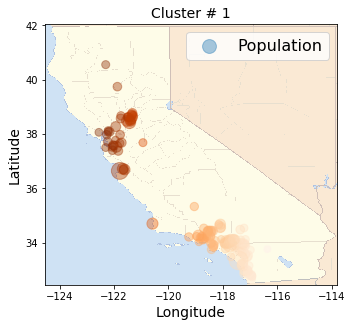

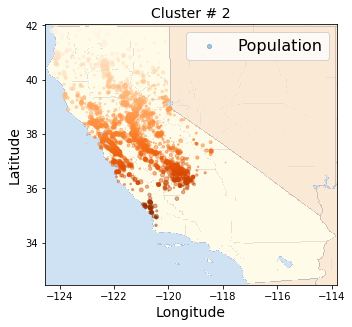

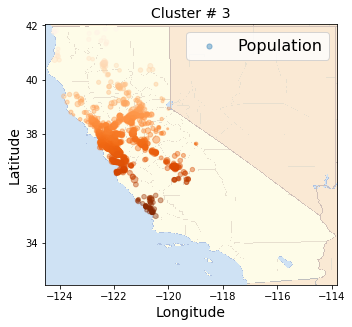

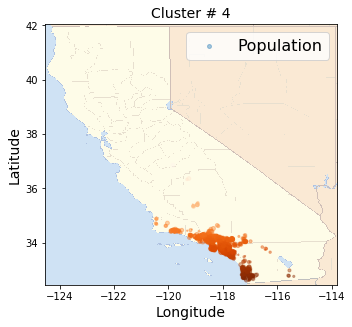

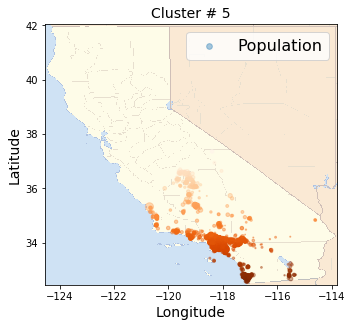

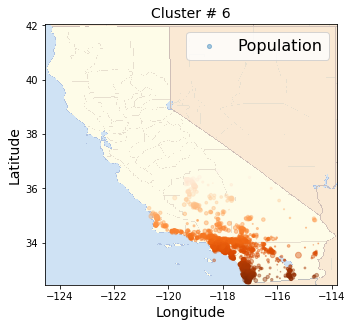

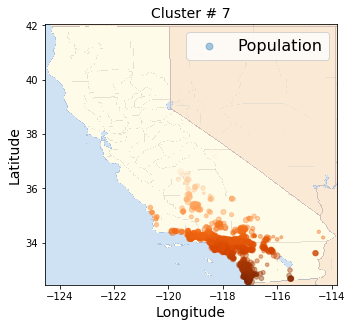

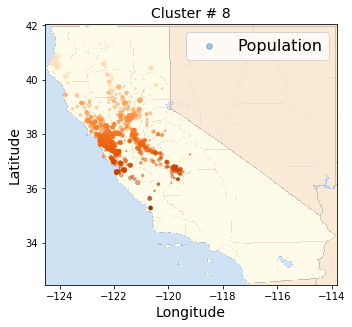

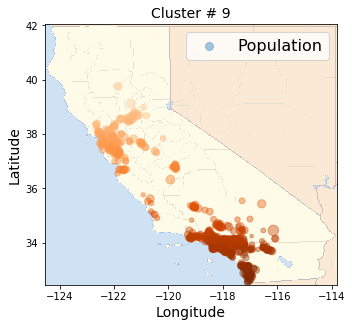

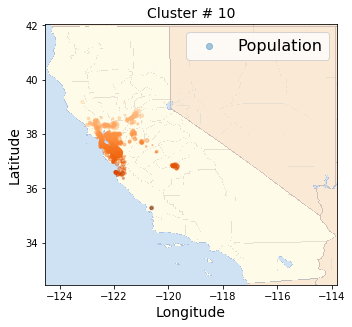

In [12]:
# Plotting first cluster of California
california_img= mpimg.imread( "california.png" )

first = dataframe_first_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_first_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=0,
                       colorbar=False, alpha=0.4)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.title( "Cluster # 1", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting second cluster of California
second = dataframe_second_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_second_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 2", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting third cluster of California
third = dataframe_third_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_third_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 3", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting fourth cluster of California
fourth = dataframe_fourth_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_fourth_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 4", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting fifth cluster of California
fifth = dataframe_fifth_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_fifth_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 5", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting sixth cluster of California
sixth = dataframe_sixth_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_sixth_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 6", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting seventh cluster of California
seventh = dataframe_seventh_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_seventh_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 7", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting eighth cluster of California
eighth = dataframe_eighth_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_eighth_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 8", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting nineth cluster of California
nineth = dataframe_nineth_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_nineth_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 9", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()


#Plotting tenth cluster of California
tenth = dataframe_tenth_cluster.plot(kind="scatter", x=0, y=1, figsize=(6.5,4.8),
                       s=dataframe_tenth_cluster[5]/100, label="Population",
                       cmap=plt.get_cmap('Oranges_r'), c=1,
                       colorbar=False, alpha=0.4,  )


plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.title( "Cluster # 10", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()





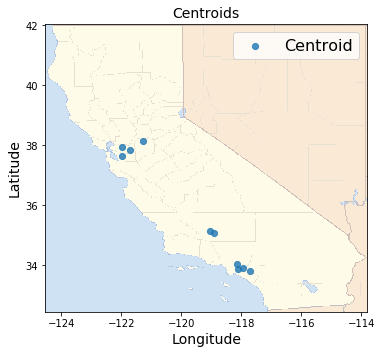

In [13]:
# Plotting latitude and longitude of centroids
         
first_centroid = lat_long_final.plot(kind="scatter", x='longitude', y='latitude', 
                                              figsize=(8,5.3), marker=".", label="Centroid", s=150, alpha=0.8)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))

plt.title( "Centroids", fontsize=14 )
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)

In [14]:
# K = 10 Analysis:
    # When K = 10, additional patterns emerge from the data. For example, we can see clear clusters in big cities like 
    # LA, San Diego, the Bay Area, San Francisco, western Fresno, Sacramento, etc. These clusters are clear indications
    # that on average, people in California prefer to life closer to the ocean. We can also see that there are some 
    # clusters that form outside in rural areas, but those are less common. The clear pattern is this: the further away 
    # you get from the ocean and big cities, the less population there will be and the costs of housing will be cheaper. 



- - -
## 4. WRITING ON THE INTUITION FOR THE CALIFORNIA HOUSING CRISIS (10 pts)

This question is a qualitative one, and is intended to let you experiment with a real world clustering task. Hopefully it gives you some intuition as for how the preset number of clusters affects the clustering results. Too few clusters may not reveal the information that is in the data. Too many clusters may hurt data analysis as well, as it may not generalize (and in this sense, it is equivalent to over fitting).

Write at least one paragraph to demonstrate your intuition on the California Housing Crisis. You might also want to mention some possible solutions to solve it. You will receive credits based upon your insights and intuitions on this challenge. 



In my opinion, the California Housing Crisis is due to a concentration of wealthy population in popular cities like LA, San Francisco and Silicon Valley. Silicon Valley and San Francisco, for example, have a very high average income 
in comparison to the rest of the state, which is what drives the prices of housing in those areas so much. In order to solve the crisis, people in cities like San Francisco who cannot afford to pay rent should move to other parts of the state where there are relatively good job opportunities, the cost of housing rent is significantly lower, and the 
amount of bedrooms and home space are bigger. By analyzing the clusters (especially the k=10 cluster data), I could deduce that the further out you go from the ocean and the closer you get to rural areas of California, the better chance people have of finding affordable housing. The life in the more rural areas of California might not be as glamorous as living in San Francisco or Silicon Valley, but at least people will be able to afford homes and avoid being homeless, which is clearly a huge problem in California (130,000 homeless people). If people who cannot afford housing in San Francisco go to the rural areas of California, they might find bigger homes at a cheaper price!

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my lectures and/or the textbook
 * Talk to the TA, they are available and there to help you during their OH.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4501 Assignment 3:...".

Best of luck and have fun!